# Import libraries

In [1]:
import os
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import scipy.io as sio

from models.LadmmNet import LADMMcsimageNet
import torch
import torch.nn as nn

gpu_list = '0'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_list
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Utility functions

In [2]:
def imread_CS_py(Iorg):
    block_size = 33
    [row, col] = Iorg.shape
    row_pad = block_size-np.mod(row,block_size)
    col_pad = block_size-np.mod(col,block_size)
    Ipad = np.concatenate((Iorg, np.zeros([row, col_pad])), axis=1)
    Ipad = np.concatenate((Ipad, np.zeros([row_pad, col+col_pad])), axis=0)
    [row_new, col_new] = Ipad.shape

    return [Iorg, row, col, Ipad, row_new, col_new]

def img2col_py(Ipad, block_size):
    [row, col] = Ipad.shape
    row_block = row/block_size
    col_block = col/block_size
    block_num = int(row_block*col_block)
    img_col = np.zeros([block_size**2, block_num])
    count = 0
    for x in range(0, row-block_size+1, block_size):
        for y in range(0, col-block_size+1, block_size):
            img_col[:, count] = Ipad[x:x+block_size, y:y+block_size].reshape([-1])
            count = count + 1
    return img_col

def col2im_CS_py(X_col, row, col, row_new, col_new):
    block_size = 33
    X0_rec = np.zeros([row_new, col_new])
    count = 0
    for x in range(0, row_new-block_size+1, block_size):
        for y in range(0, col_new-block_size+1, block_size):
            X0_rec[x:x+block_size, y:y+block_size] = X_col[:, count].reshape([block_size, block_size])
            count = count + 1
    X_rec = X0_rec[:row, :col]
    return X_rec

# Measurement matrices

In [3]:
fname1       = 'H.mat'
data_path    = os.path.join(os.getcwd(),'data/GrayscaleImages/Clean_measurements_25')
H            = sio.loadmat(os.path.join(data_path, fname1))['H']
H            = torch.from_numpy(H).type(torch.FloatTensor)
H            = H.to(device)

# LADMM parameters

In [4]:
M = 256
N = 256
L = 1

layer_num               = 16 
learning_rate           = 0.001
epochs                  = 512
num_training_samples    = 80
num_samples             = 80
batch_size              = 1
num_processed_images    = 1
compression_rate        = 25

model     = LADMMcsimageNet(layer_num)
model     = nn.DataParallel(model)
model     = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

sample_path     = os.path.join(os.getcwd(),'data/GrayscaleImages/testimages/Clean_measurements_25')
data_path       = os.path.join(os.getcwd(),'data/GrayscaleImages/testimages')
prmt_path       = os.path.join(os.getcwd(),'train_parameters/GrayscaleImages/LADMM_Net_layer_%d_ratio_%d'%(layer_num, compression_rate))
model_dir = "./train_parameters/GrayscaleImages/LADMM_Net_layer_%d_ratio_%d" % (layer_num, compression_rate)
model.load_state_dict(torch.load('./%s/net_params_%d.pkl' % (model_dir, epochs)))

<All keys matched successfully>

# Testing stage

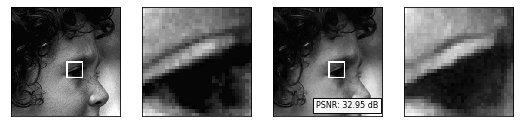

In [5]:
fpointer        = 3
filename        = 'samples_%03d.mat'%(fpointer)
y               = sio.loadmat(os.path.join(sample_path, filename))['y']
y               = torch.from_numpy(y).type(torch.FloatTensor).to(device)
HTy             = torch.t(torch.mm(torch.t(H), y)).to(device)

[x_test, loss_layers_sym] = model(H, HTy, 33, 33)

fimage          = 'gray_%03d.mat'%(fpointer)
I               = sio.loadmat(os.path.join(data_path, fimage))['I']
[Iorg, row, col, Ipad, row_new, col_new] = imread_CS_py(I)
x   = img2col_py(Ipad, 33) / 255.0       
x   = torch.from_numpy(x).type(torch.FloatTensor)
x   = torch.t(x).to(device)


#x1 = 110
#x2 = x1+33
#y1 = 99
#y2 = y1 + 33
#wd = 3

#x3 = 120
#x4 = 150
#y3 = 180
#y4 = 240


x1 = 132
x2 = x1+33
y1 = 132
y2 = y1 + 33
wd = 3

x3 = 120
x4 = 150
y3 = 180
y4 = 240

I[x1:x2,y1-wd:y1]=255
I[x1:x2,y2:y2+wd]=255
I[x1-wd:x1,y1-wd:y2+wd]=255
I[x2:x2+wd,y1-wd:y2+wd]=255

plt.figure(figsize=(9,4))

plt.subplot(1,4,1)
plt.xticks([])
plt.yticks([])
plt.imshow(I, cmap='gray')

plt.subplot(1,4,2)
plt.xticks([])
plt.yticks([])
plt.imshow(I[x1:x2,y1:y2], cmap='gray')


Prediction_value = x.cpu().data.numpy()
I = 255 * np.clip(col2im_CS_py(Prediction_value.transpose(), row, col, row_new, col_new), 0, 1)

Prediction_value = x_test.cpu().data.numpy()
Io= 255 * np.clip(col2im_CS_py(Prediction_value.transpose(), row, col, row_new, col_new), 0, 1)

loss_discrepancy    = np.mean(np.power(Io - I, 2))
psnr                = torch.mul(10, torch.log10(torch.div(255*255, loss_discrepancy))) 

Io[x1:x2,y1-wd:y1]=255
Io[x1:x2,y2:y2+wd]=255
Io[x1-wd:x1,y1-wd:y2+wd]=255
Io[x2:x2+wd,y1-wd:y2+wd]=255

plt.subplot(1,4,3)
plt.xticks([])
plt.yticks([])
plt.imshow(Io, cmap='gray')
plt.text(100, 235, 'PSNR: %.2f dB'%(psnr), fontsize=8,
        bbox={'facecolor': 'white', 'alpha': 0.95, 'pad': 3})

plt.subplot(1,4,4)
plt.xticks([])
plt.yticks([])
plt.imshow(Io[x1:x2,y1:y2], cmap='gray')
plt.savefig('test.png', dpi=300)